In [1]:
import numpy as np
import pandas as pd
from functions import loadMultiParquet, cut, getXSectionBR
from helpersForNN import preprocessMultiClass, scale, unscale
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import mplhep as hep
hep.style.use("CMS")
import glob, re, sys
import math
from applyMultiClass_Hpeak import getPredictions, splitPtFunc

ModuleNotFoundError: No module named 'helpersForNN'

In [2]:
pTClass, nReal, nMC = 0, 300, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/others",
            ]


# load the files where the prediction is available
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=-1, columns=['sf', 'dijet_mass', 'dijet_pt', 'jet1_pt', 'jet2_pt','jet1_mass', 'jet2_mass', 'jet1_eta', 'jet2_eta', 'jet1_qgl', 'jet2_qgl', 'dijet_dR', 'dijet_dPhi'], returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    
dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class


944  predictions files for process MC :  0
154  predictions files for process MC :  1
1580  predictions files for process MC :  36
162  predictions files for process MC :  20
249  predictions files for process MC :  21
241  predictions files for process MC :  22
210  predictions files for process MC :  23
Looking for a specific list of  944  files expected
Found 347 files for process 0
300 files for process 0


Looking for a specific list of  154  files expected
Found 154 files for process 1
154 files for process 1


Looking for a specific list of  1580  files expected
Found 1580 files for process 2
1580 files for process 2


Looking for a specific list of  162  files expected
Found 110 files for process 3
110 files for process 3


Looking for a specific list of  249  files expected
Found 110 files for process 4
110 files for process 4


Looking for a specific list of  241  files expected
Found 110 files for process 5
110 files for process 5


Looking for a specific list of  210  files

In [3]:
minPt, maxPt = None, None #180, -1
if (minPt is not None) | (maxPt is not None):
    dfs, masks = splitPtFunc(dfs, minPt, maxPt)
    splitPt = True
else:
    masks=None
    splitPt=False
        
W = dfs[0].sf
W_H = dfs[1].sf*getXSectionBR()/numEventsList[1]*nReal*0.774/1017*1000
W_1 = 5.261e+03/numEventsList[2]*dfs[2].sf*nReal*0.774/1017*1000
W_2 = 1012./numEventsList[3]*dfs[3].sf*nReal*0.774/1017*1000
W_3 = 114.2/numEventsList[4]*dfs[4].sf*nReal*0.774/1017*1000
W_4 = 25.34/numEventsList[5]*dfs[5].sf*nReal*0.774/1017*1000
W_5 = 12.99/numEventsList[6]*dfs[6].sf*nReal*0.774/1017*1000
dfs = [dfs[0], dfs[1], pd.concat(dfs[2:])]

W_Z = np.concatenate([W_1, W_2, W_3, W_4, W_5])

In [4]:
YPred_data, YPred_H, YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf = getPredictions(fileNumberList, pathToPredictions, splitPt=splitPt, masks=masks, isMC=isMCList, pTClass=pTClass)
YPred_Z = np.concatenate((YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf))

In [5]:
mdata=((dfs[0].jet1_pt>20) & (dfs[0].jet2_pt>20))
mH=((dfs[1].jet1_pt>20) & (dfs[1].jet2_pt>20))
mZ=((dfs[2].jet1_pt>20) & (dfs[2].jet2_pt>20))
dfs[0]=dfs[0][mdata]
dfs[1]=dfs[1][mH]
dfs[2]=dfs[2][mZ]
YPred_H=YPred_H[mH]
YPred_Z=YPred_Z[mZ]
YPred_data=YPred_data[mdata]
W_Z=W_Z[mZ]
W_H=W_H[mH]


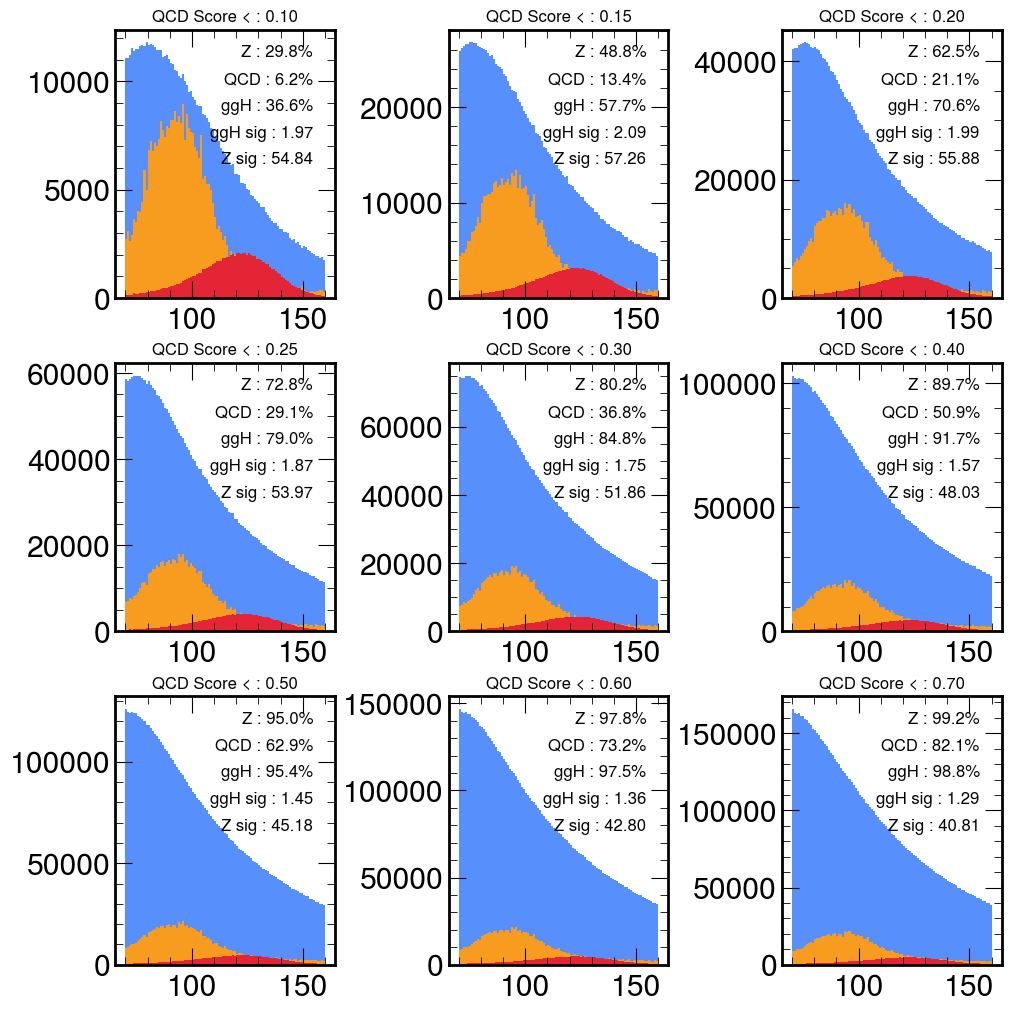

In [22]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)
massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)
t = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]
        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("QCD Score < : %.2f"%(t[i*ncols+j]), fontsize=12)

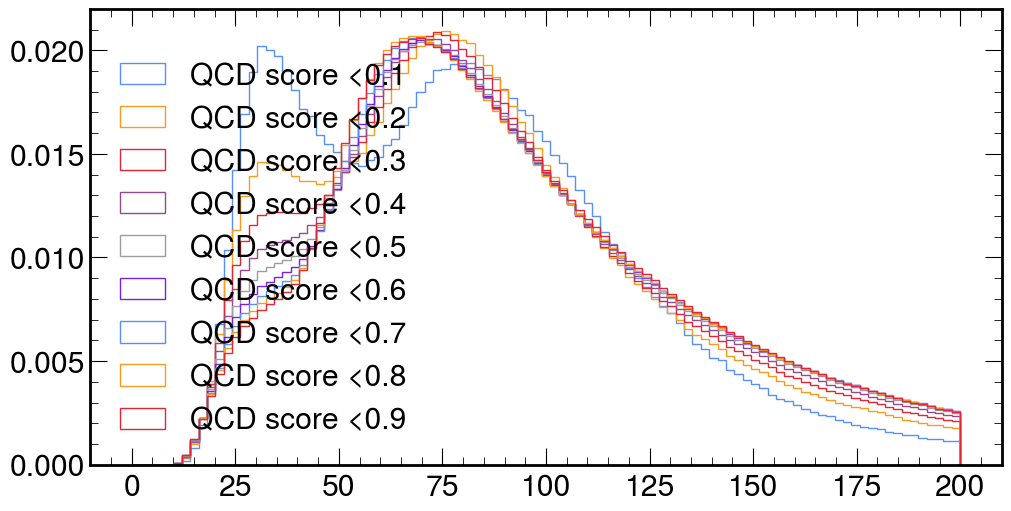

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/dfs[0].sf[mask_data].sum(), label='QCD score <%.1f'%t[i*ncols+j], histtype=u'step')[0]
ax.legend()

Text(0.5, 1.0, 'Dijet Mass : ggH score scan')

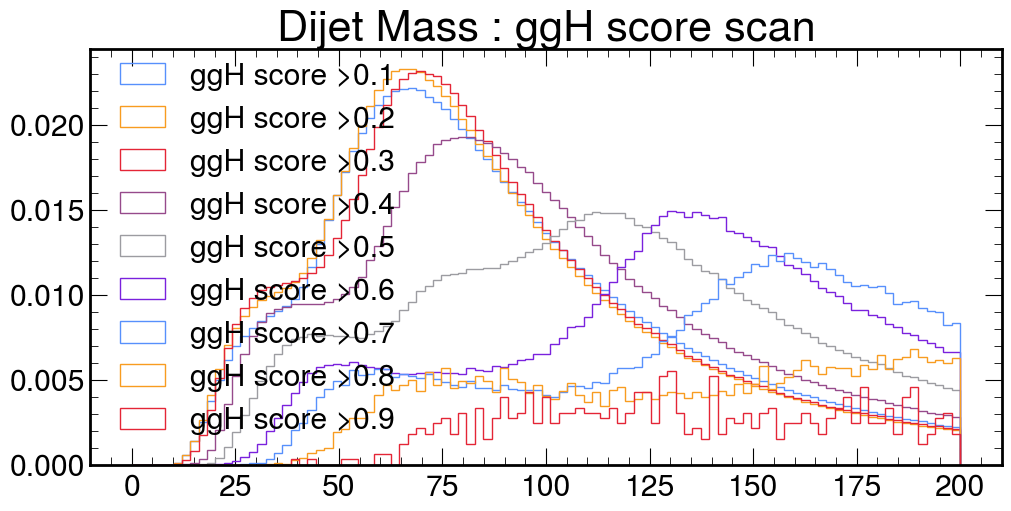

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(t)):
        mask_data = (YPred_data[:,1]>t[i]) 
        mask_Z = YPred_Z[:,1]>t[i]
        mask_H = YPred_H[:,1]>t[i]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/np.sum(dfs[0].sf[mask_data]), label='ggH score >%.1f'%t[i], histtype=u'step')[0]
ax.legend()

ax.set_title("Dijet Mass : ggH score scan")

Text(0.5, 1.0, 'Dijet Mass : ggH score scan for dijetPt>100')

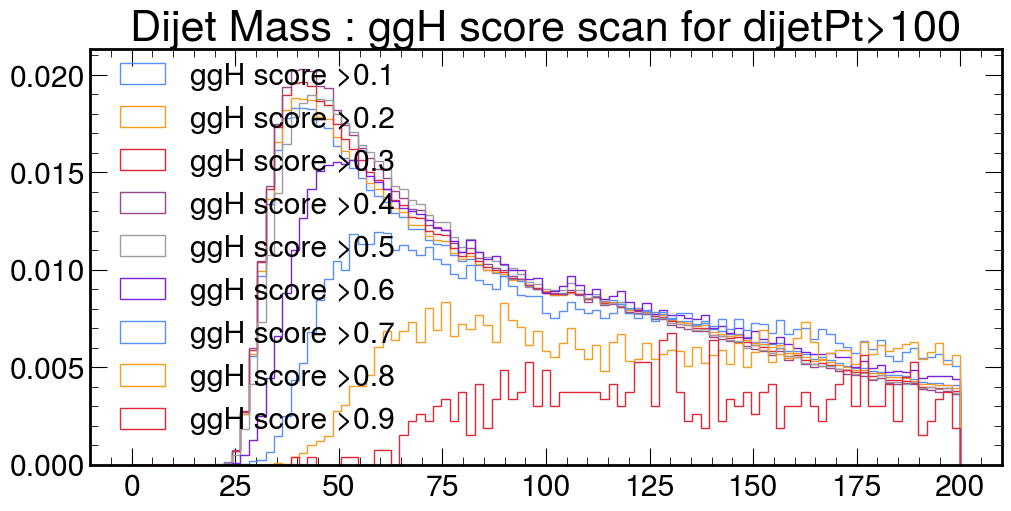

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dijet_threshold=100
for i in range(len(t)):
        mask_data = (YPred_data[:,1]>t[i]) & (dfs[0].dijet_pt>dijet_threshold)
        mask_Z = YPred_Z[:,1]>t[i]
        mask_H = YPred_H[:,1]>t[i]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/np.sum(dfs[0].sf[mask_data]), label='ggH score >%.1f'%t[i], histtype=u'step')[0]
ax.legend()

ax.set_title("Dijet Mass : ggH score scan for dijetPt>%d"%dijet_threshold)

Text(0.5, 1.0, 'Dijet Mass : ggH score>0.5')

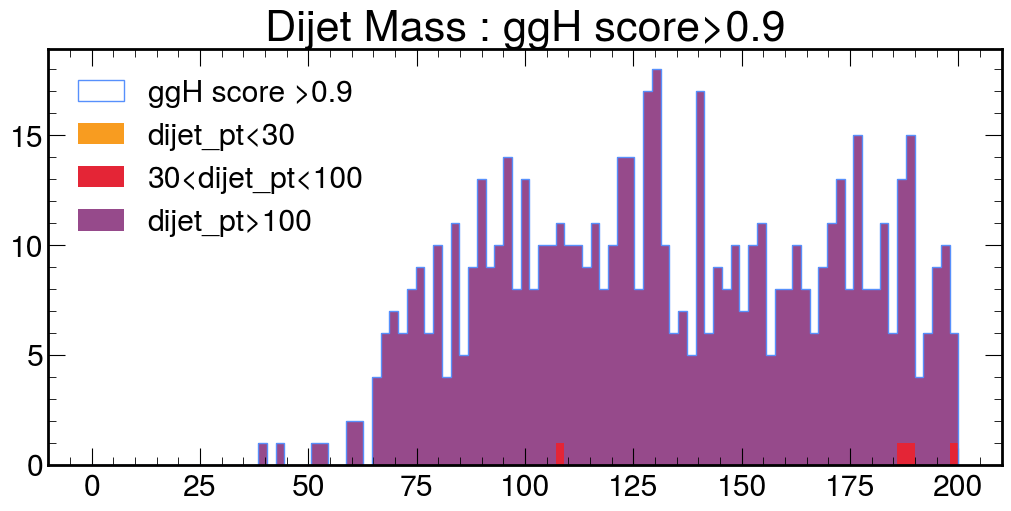

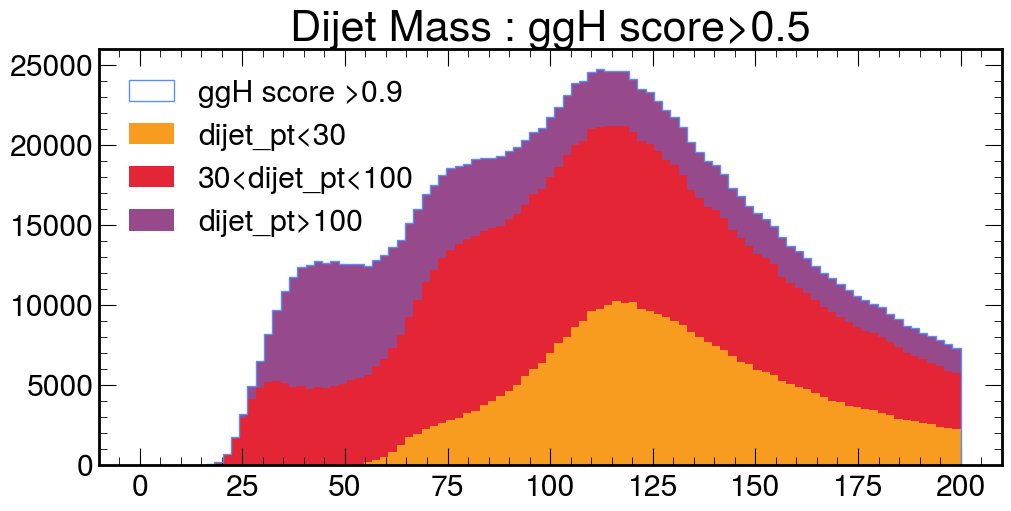

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

ptlow, ptmed = 30, 100
ggH_score = 0.9
mask_data = (YPred_data[:,1]>ggH_score) 
mask_Z = YPred_Z[:,1]>ggH_score
mask_H = YPred_H[:,1]>ggH_score
ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data], label='ggH score >%.1f'%0.9, histtype=u'step')[0]
c_low = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt < ptlow)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt < ptlow)], label='dijet_pt<%d'%ptlow)[0]
c_med = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt>ptlow) & (dfs[0].dijet_pt<ptmed)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt>ptlow) & (dfs[0].dijet_pt<ptmed)], label='%d<dijet_pt<%d'%(ptlow, ptmed), bottom=c_low)[0]
c_hig = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt>ptmed)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt>ptmed)], label='dijet_pt>%d'%ptmed, bottom=c_low+c_med)[0]

ax.legend()

ax.set_title("Dijet Mass : ggH score>%.1f"%ggH_score)




fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

ptlow, ptmed = 30, 100
ggH_score = 0.5
mask_data = (YPred_data[:,1]>ggH_score) 
mask_Z = YPred_Z[:,1]>ggH_score
mask_H = YPred_H[:,1]>ggH_score
ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data], label='ggH score >%.1f'%0.9, histtype=u'step')[0]
c_low = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt < ptlow)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt < ptlow)], label='dijet_pt<%d'%ptlow)[0]
c_med = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt>ptlow) & (dfs[0].dijet_pt<ptmed)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt>ptlow) & (dfs[0].dijet_pt<ptmed)], label='%d<dijet_pt<%d'%(ptlow, ptmed), bottom=c_low)[0]
c_hig = ax.hist(dfs[0].dijet_mass[(mask_data) & (dfs[0].dijet_pt>ptmed)], bins=bins, weights=dfs[0].sf[(mask_data) & (dfs[0].dijet_pt>ptmed)], label='dijet_pt>%d'%ptmed, bottom=c_low+c_med)[0]

ax.legend()

ax.set_title("Dijet Mass : ggH score>%.1f"%ggH_score)

Text(0.5, 1.0, 'Dijet Mass for ggH MC')

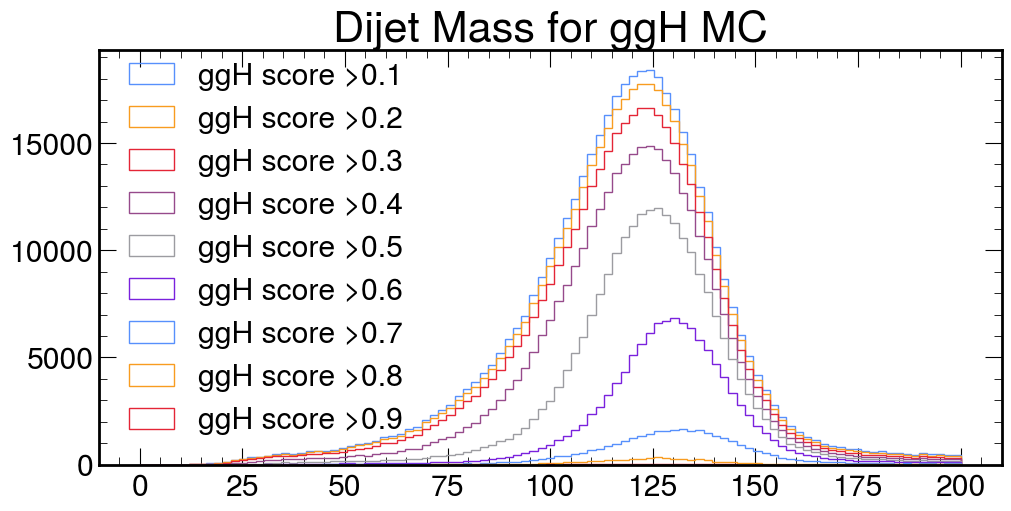

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(t)):
        mask_data = YPred_data[:,1]>t[i]
        mask_Z = YPred_Z[:,1]>t[i]
        mask_H = YPred_H[:,1]>t[i]
        ax.hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=dfs[1].sf[mask_H], label='ggH score >%.1f'%t[i], histtype=u'step')[0]
ax.legend()
#ax.set_yscale('log')

ax.set_title("Dijet Mass for ggH MC")

Text(0.5, 1.0, 'Dijet Mass for ggH MC')

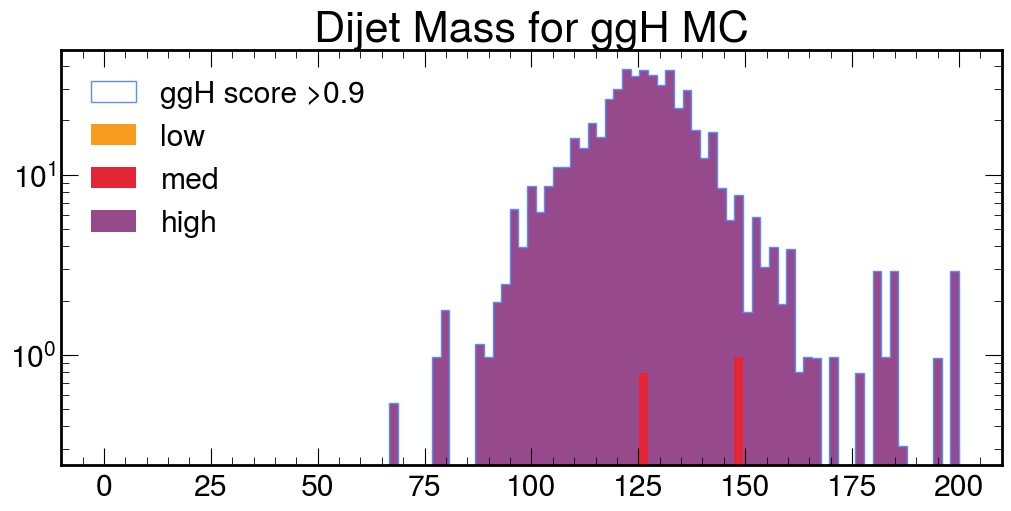

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)
ggH_score=0.9

mask_data = (YPred_data[:,1]>ggH_score)
mask_Z = YPred_Z[:,1]>ggH_score
mask_H = YPred_H[:,1]>ggH_score
ax.hist(dfs[1].dijet_mass[(mask_H)], bins=bins, weights=dfs[1].sf[(mask_H)], label='ggH score >%.1f'%ggH_score, histtype=u'step')[0]
c_l = ax.hist(dfs[1].dijet_mass[(mask_H) & (dfs[1].dijet_pt<ptlow)], bins=bins, weights=dfs[1].sf[(mask_H) & (dfs[1].dijet_pt<ptlow)], label='low')[0]
c_m=ax.hist(dfs[1].dijet_mass[(mask_H) & (dfs[1].dijet_pt>ptlow) & (dfs[1].dijet_pt<ptmed)], bins=bins, weights=dfs[1].sf[(mask_H) & (dfs[1].dijet_pt>ptlow) & (dfs[1].dijet_pt<ptmed)], label='med', bottom=c_l)[0]
c_h=ax.hist(dfs[1].dijet_mass[(mask_H) & (dfs[1].dijet_pt>ptmed)], bins=bins, weights=dfs[1].sf[(mask_H) & (dfs[1].dijet_pt>ptmed)], label='high', bottom=c_l+c_m)[0]
ax.legend()
ax.set_yscale('log')
ax.set_title("Dijet Mass for ggH MC")

In [13]:
dfs[0].columns

Index(['sf', 'dijet_mass', 'dijet_pt', 'jet1_pt', 'jet2_pt', 'jet1_mass',
       'jet2_mass', 'jet1_eta', 'jet2_eta', 'jet1_qgl', 'jet2_qgl', 'dijet_dR',
       'dijet_dPhi'],
      dtype='object')

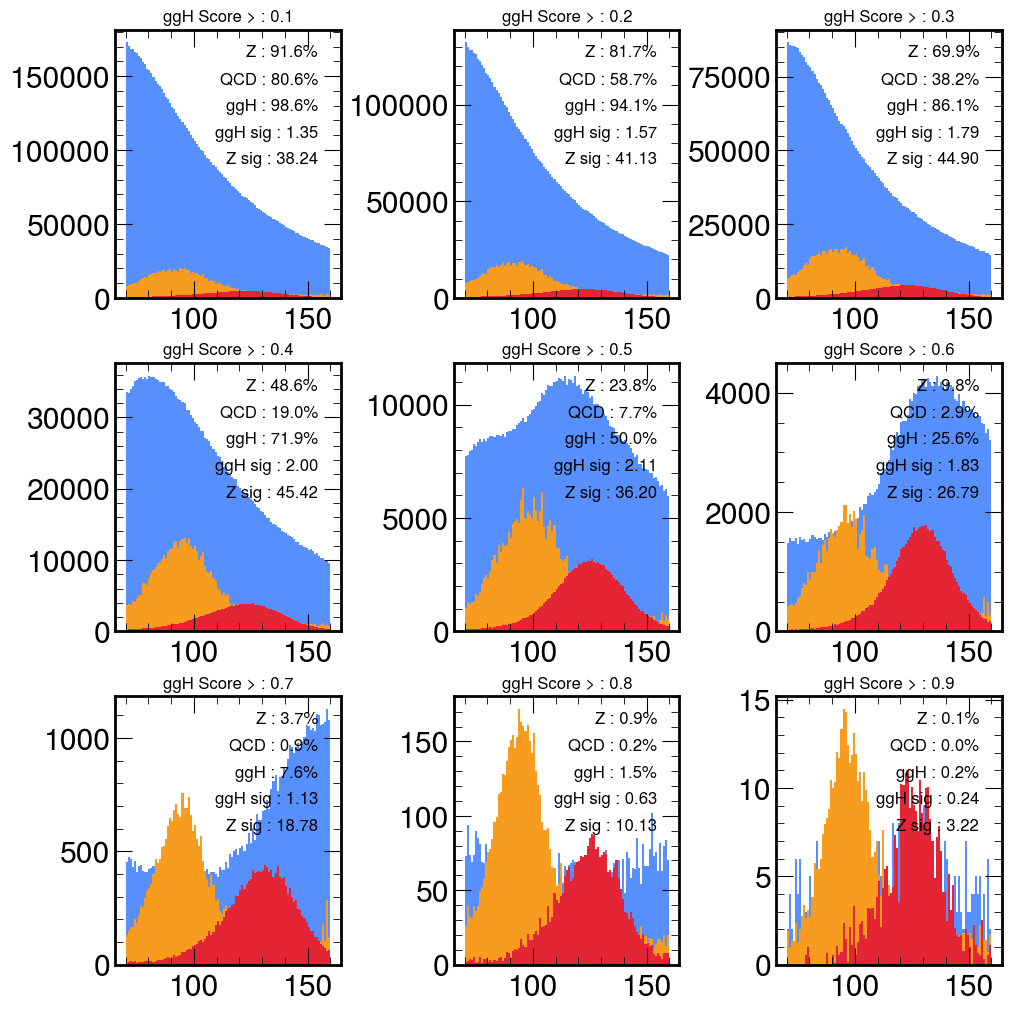

In [14]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)


massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):

        mask_data = (YPred_data[:,1]>t[i*ncols+j]) 
        mask_H = (YPred_H[:,1]>t[i*ncols+j]) 
        mask_Z = (YPred_Z[:,1]>t[i*ncols+j]) 
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("ggH Score > : %.1f"%(t[i*ncols+j]), fontsize=12)

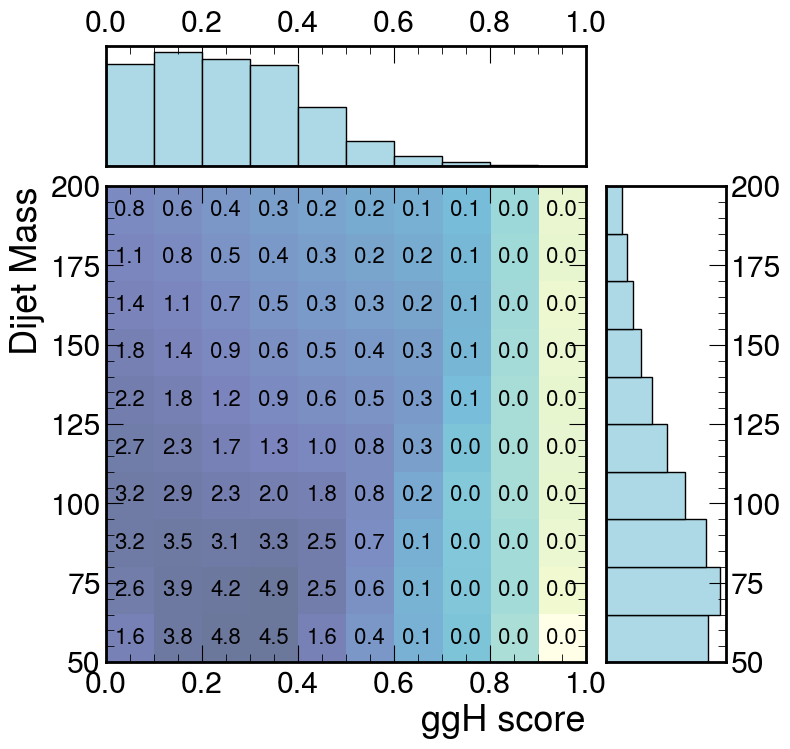

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
x_bins, y_bins = np.linspace(0, 1, 11), np.linspace(50, 200, 11)
fig, ax_main = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax_main)
ax_top = divider.append_axes("top", 1.2, pad=0.2, sharex=ax_main)
ax_right = divider.append_axes("right", 1.2, pad=0.2, sharey=ax_main)


xvar = YPred_data[:,1]
yvar = dfs[0].dijet_mass
# Plot the 2D histogram in the main axes
hist, x_edges, y_edges = np.histogram2d(x=xvar, y=yvar, bins=[x_bins, y_bins])
ax_main.imshow(hist.T, origin='lower', extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()), aspect='auto', cmap='YlGnBu', alpha=0.6, norm=LogNorm())
hist=hist/np.sum(hist)*100
for y in range(len(y_bins)-1):
    for x in range(len(x_bins)-1):
        ax_main.text((x+0.5)/(len(y_bins)-1) , (y+0.5)/(len(y_bins)-1) , '%.1f' % hist[x, y],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                transform=ax_main.transAxes

                )
ax_main.set_xlabel("ggH score")
ax_main.set_ylabel("Dijet Mass")

# Plot the marginalized histogram on top
ax_top.hist(xvar, bins=x_bins, color='lightblue', edgecolor='black')
ax_top.set_xlim(ax_main.get_xlim())
ax_top.set_yticks([])
ax_top.xaxis.tick_top()

# Plot the marginalized histogram on the right
ax_right.hist(yvar, bins=y_bins, color='lightblue', edgecolor='black', orientation='horizontal')#lightcoral
ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])
ax_right.yaxis.tick_right()

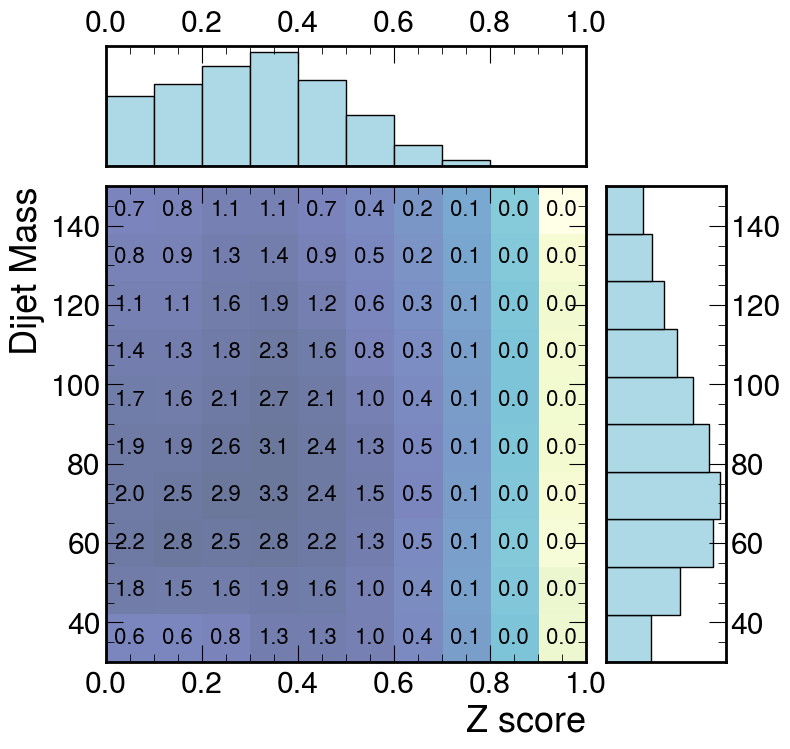

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
x_bins, y_bins = np.linspace(0, 1, 11), np.linspace(30, 150, 11)
fig, ax_main = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax_main)
ax_top = divider.append_axes("top", 1.2, pad=0.2, sharex=ax_main)
ax_right = divider.append_axes("right", 1.2, pad=0.2, sharey=ax_main)


xvar = YPred_data[:,2]
yvar = dfs[0].dijet_mass
# Plot the 2D histogram in the main axes
hist, x_edges, y_edges = np.histogram2d(x=xvar, y=yvar, bins=[x_bins, y_bins])
ax_main.imshow(hist.T, origin='lower', extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()), aspect='auto', cmap='YlGnBu', alpha=0.6, norm=LogNorm())
hist=hist/np.sum(hist)*100
for y in range(len(y_bins)-1):
    for x in range(len(x_bins)-1):
        ax_main.text((x+0.5)/(len(y_bins)-1) , (y+0.5)/(len(y_bins)-1) , '%.1f' % hist[x, y],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                transform=ax_main.transAxes

                )
ax_main.set_xlabel("Z score")
ax_main.set_ylabel("Dijet Mass")

# Plot the marginalized histogram on top
ax_top.hist(xvar, bins=x_bins, color='lightblue', edgecolor='black')
ax_top.set_xlim(ax_main.get_xlim())
ax_top.set_yticks([])
ax_top.xaxis.tick_top()

# Plot the marginalized histogram on the right
ax_right.hist(yvar, bins=y_bins, color='lightblue', edgecolor='black', orientation='horizontal')#lightcoral
ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])
ax_right.yaxis.tick_right()

### Hyp: ggH score > 0.3 as good compromise between shaping and significance
Now scan on QCD score

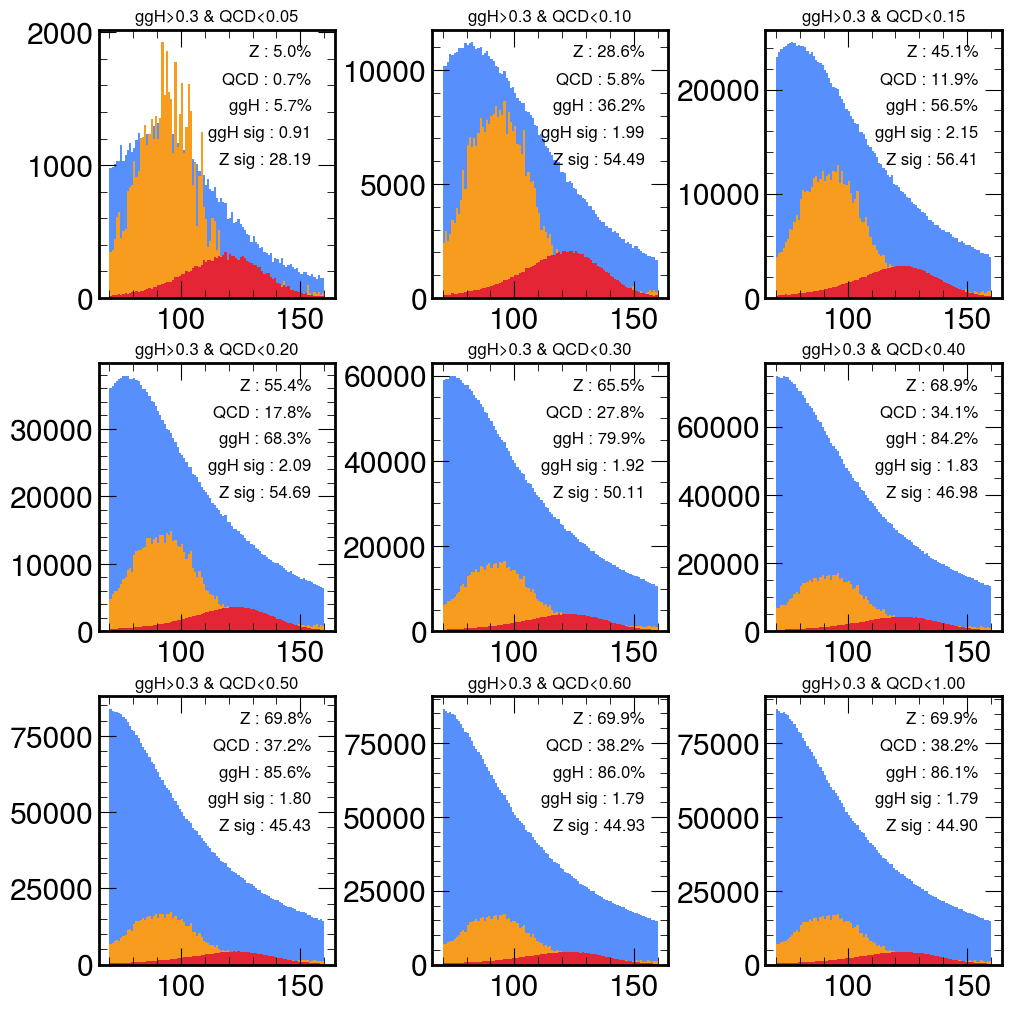

In [17]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)
massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)
t = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.999]
ggH_threhsold = 0.3
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,1]>ggH_threhsold
        mask_H = YPred_H[:,1]>ggH_threhsold
        mask_Z = YPred_Z[:,1]>ggH_threhsold
        mask_data = (mask_data) & (YPred_data[:,0]<t[i*ncols+j])
        mask_H = (mask_H) & (YPred_H[:,0]<t[i*ncols+j])
        mask_Z = (mask_Z) & (YPred_Z[:,0]<t[i*ncols+j])
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')


        ax[i,j].set_title("ggH>%.1f & QCD<%.2f"%(ggH_threhsold,t[i*ncols+j]), fontsize=12)

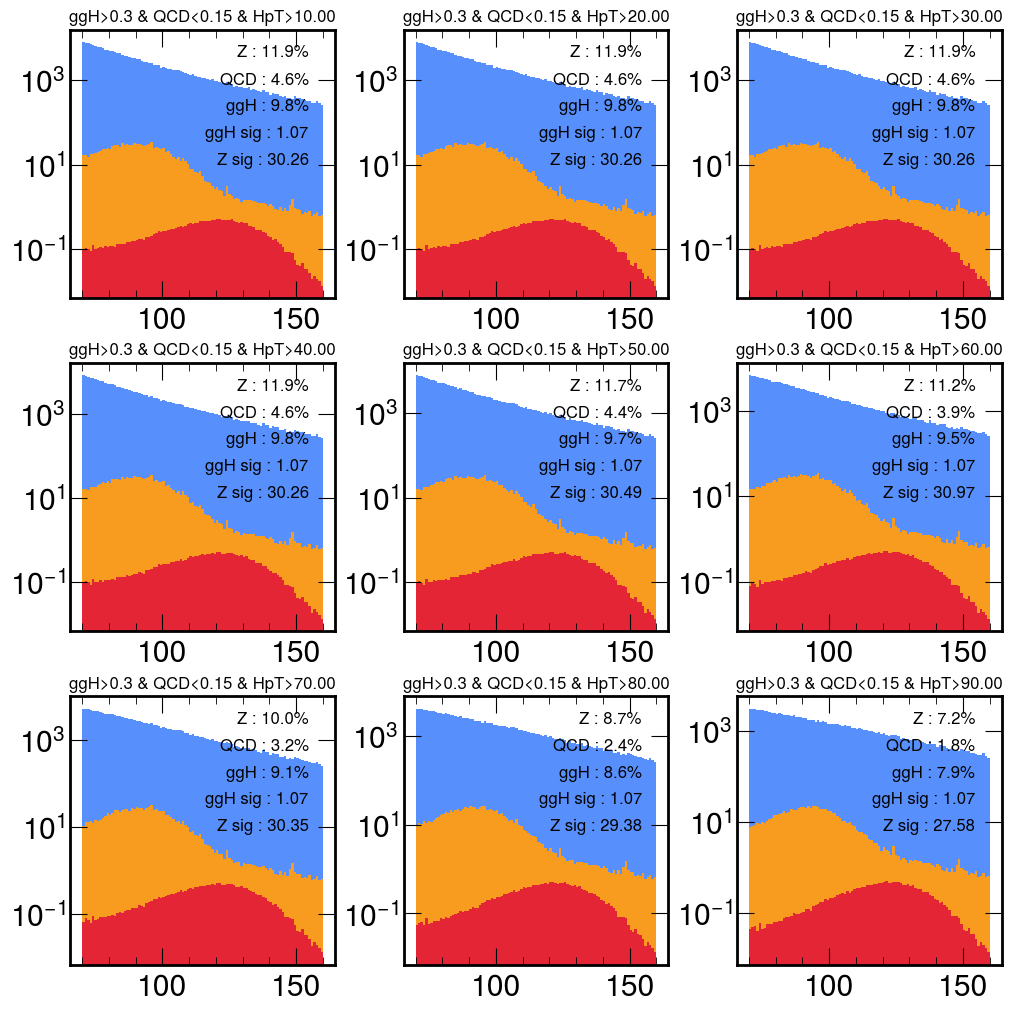

In [18]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)
massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)
#t = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.999]
t = [10,20, 30, 40, 50, 60, 70, 80, 90]
ggH_threhsold = 0.3
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,1]>ggH_threhsold
        mask_H = YPred_H[:,1]>ggH_threhsold
        mask_Z = YPred_Z[:,1]>ggH_threhsold
        mask_data = (mask_data) & (YPred_data[:,0]<0.15) & (dfs[0].dijet_pt>t[i*ncols+j]) & (dfs[0].dijet_dR<2)
        mask_H = (mask_H) & (YPred_H[:,0]<0.15) & (dfs[1].dijet_pt>t[i*ncols+j]) & (dfs[1].dijet_dR<2)
        mask_Z = (mask_Z) & (YPred_Z[:,0]<0.15) & (dfs[2].dijet_pt>t[i*ncols+j]) & (dfs[2].dijet_dR<2)
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z])[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H])[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_yscale('log')
        


        ax[i,j].set_title("ggH>%.1f & QCD<%.2f & HpT>%.2f"%(ggH_threhsold,0.15, t[i*ncols+j]), fontsize=12)

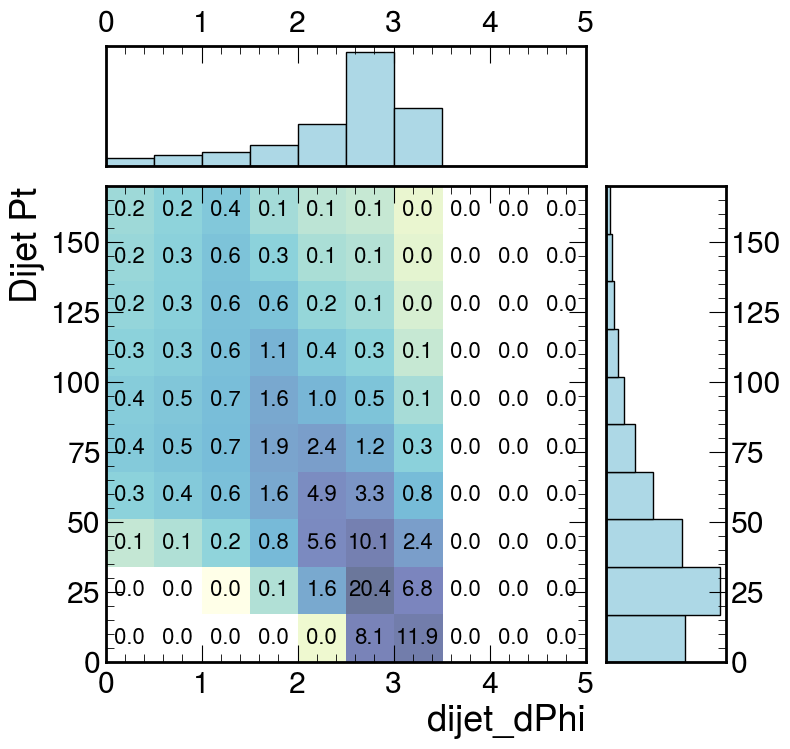

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, ax_main = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax_main)
ax_top = divider.append_axes("top", 1.2, pad=0.2, sharex=ax_main)
ax_right = divider.append_axes("right", 1.2, pad=0.2, sharey=ax_main)


xvar = dfs[1].dijet_dPhi
yvar = dfs[1].dijet_pt
x_bins, y_bins = np.linspace(0, 5, 11), np.linspace(0, 170, 11)
# Plot the 2D histogram in the main axes
hist, x_edges, y_edges = np.histogram2d(x=xvar, y=yvar, bins=[x_bins, y_bins])
ax_main.imshow(hist.T, origin='lower', extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()), aspect='auto', cmap='YlGnBu', alpha=0.6, norm=LogNorm())
hist=hist/np.sum(hist)*100
for y in range(len(y_bins)-1):
    for x in range(len(x_bins)-1):
        ax_main.text((x+0.5)/(len(y_bins)-1) , (y+0.5)/(len(y_bins)-1) , '%.1f' % hist[x, y],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                transform=ax_main.transAxes

                )
ax_main.set_xlabel("dijet_dPhi")
ax_main.set_ylabel("Dijet Pt")

# Plot the marginalized histogram on top
ax_top.hist(xvar, bins=x_bins, color='lightblue', edgecolor='black')
ax_top.set_xlim(ax_main.get_xlim())
ax_top.set_yticks([])
ax_top.xaxis.tick_top()

# Plot the marginalized histogram on the right
ax_right.hist(yvar, bins=y_bins, color='lightblue', edgecolor='black', orientation='horizontal')#lightcoral
ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])
ax_right.yaxis.tick_right()

(array([0.        , 0.        , 0.00043271, 0.00257081, 0.00637544,
        0.0099242 , 0.01195647, 0.01189819, 0.01030132, 0.00861335,
        0.0068383 , 0.00555758, 0.00459771, 0.00397544, 0.00326274,
        0.00272286, 0.00235914, 0.00194184, 0.0016719 ]),
 array([  0.        ,  10.52631579,  21.05263158,  31.57894737,
         42.10526316,  52.63157895,  63.15789474,  73.68421053,
         84.21052632,  94.73684211, 105.26315789, 115.78947368,
        126.31578947, 136.84210526, 147.36842105, 157.89473684,
        168.42105263, 178.94736842, 189.47368421, 200.        ]),
 [<matplotlib.patches.Polygon at 0x7f90d603dd50>])

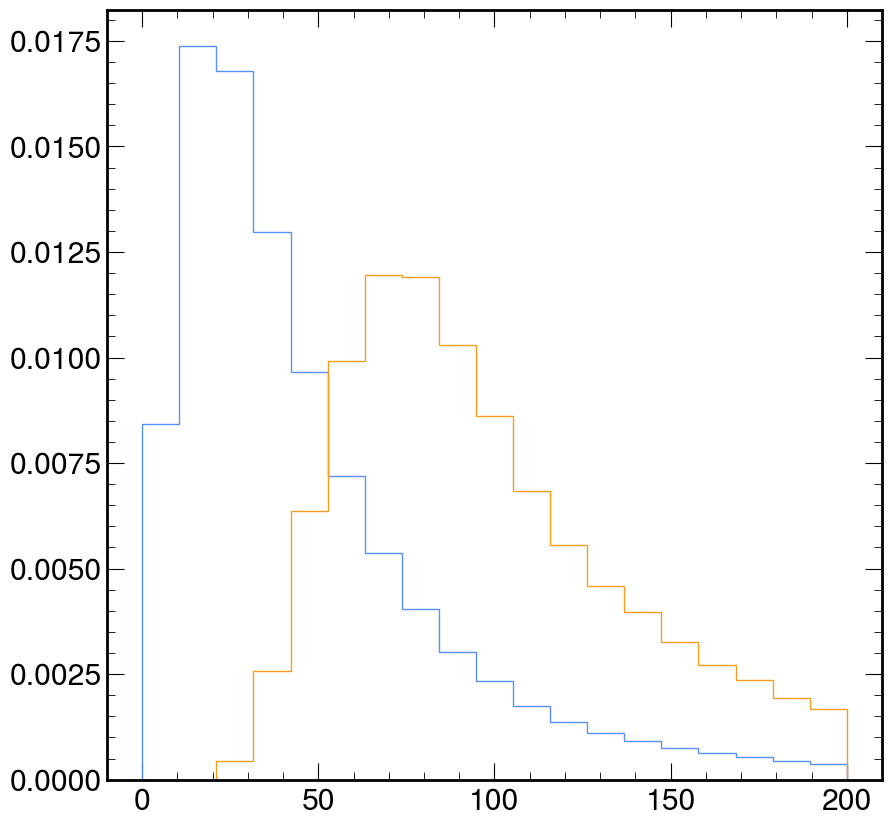

In [24]:
fgi, ax =plt.subplots(1, 1)
bins=np.linspace(0, 200, 20)
ax.hist(dfs[1].dijet_pt, bins=bins, density=True, histtype=u'step')
ax.hist(dfs[1].dijet_pt[dfs[1].dijet_dPhi<2.1], bins=bins, density=True, histtype=u'step')